In [5]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.linear_model import LinearRegression

In [6]:
data = pd.read_csv('ALL_data.csv', index_col='PID')
sector = pd.read_csv('sectors_walmart.csv', index_col='PID')
data = data.merge(sector[['Sector','DfromWalmart']], on='PID')
data.columns

Index(['GrLivArea', 'SalePrice', 'MSSubClass', 'MSZoning', 'LotFrontage',
       'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'Pav

## Look at <span style="color:darkred">Sales Prices</span> 💵

In [7]:
y = data.SalePrice.copy()

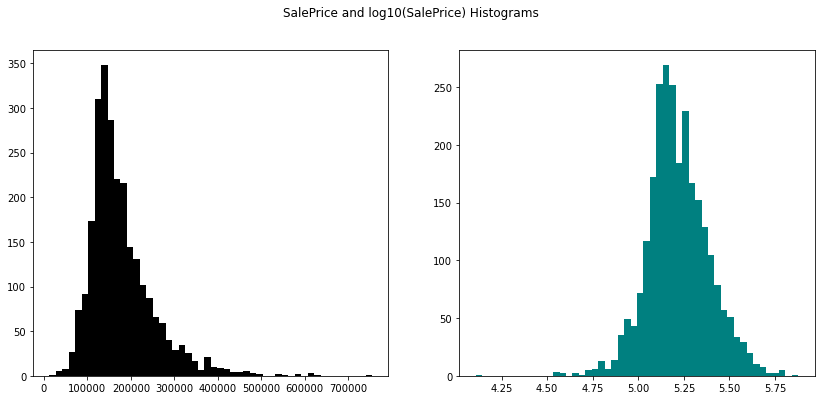

In [8]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('SalePrice and log10(SalePrice) Histograms')

ax1.hist(y, bins=50,color='k');
ax2.hist(np.log10(y), bins=50, color='teal');

## <span style="color:darkred">Land-based</span> features ⛰️
* MSZoning / LotArea / LotShape / LandContour / Utilities / LandSlope / Condition1 / Condition2 / Sector

In [9]:
landfeats = data[['MSZoning','LotArea','LotShape','LandContour','Utilities',
                  'LandSlope','Condition1','Condition2','Neighborhood','Sector']].copy()

**Numeric Features:** LotArea

In [10]:
landfeats.LotArea.describe()

count      2579.000000
mean      10119.269484
std        8128.389882
min        1300.000000
25%        7406.500000
50%        9382.000000
75%       11485.500000
max      215245.000000
Name: LotArea, dtype: float64

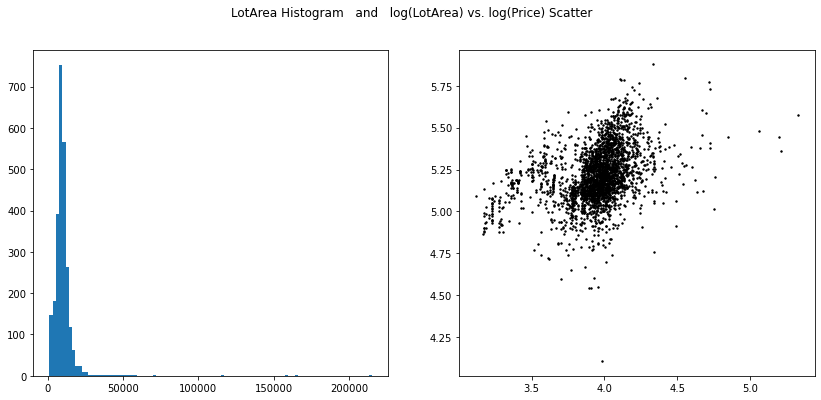

In [11]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('LotArea Histogram   and   log(LotArea) vs. log(Price) Scatter')

ax1.hist(landfeats.LotArea, bins=100)
ax2.scatter(x=np.log10(landfeats.LotArea),y=np.log10(y),s=2,c='k')

**Categorical Features:** MSZoning / LotShape / LandContour / Utilities / LandSlope / Condition1 / Condition2 / Sector

In [12]:
for col in landfeats.drop('LotArea', axis=1).columns:
    print(landfeats[col].value_counts())
    print('---------------------------')

RL         2007
RM          418
FV          113
RH           21
C (all)      17
I (all)       2
A (agr)       1
Name: MSZoning, dtype: int64
---------------------------
Reg    1640
IR1     855
IR2      71
IR3      13
Name: LotShape, dtype: int64
---------------------------
Lvl    2337
Bnk      95
HLS      95
Low      52
Name: LandContour, dtype: int64
---------------------------
AllPub    2577
NoSewr       2
Name: Utilities, dtype: int64
---------------------------
Gtl    2458
Mod     108
Sev      13
Name: LandSlope, dtype: int64
---------------------------
Norm      2227
Feedr      137
Artery      81
RRAn        40
PosN        37
RRAe        26
PosA        19
RRNn         8
RRNe         4
Name: Condition1, dtype: int64
---------------------------
Norm      2554
Feedr       12
Artery       3
PosA         3
PosN         3
RRNn         2
RRAn         1
RRAe         1
Name: Condition2, dtype: int64
---------------------------
NAmes      410
CollgCr    236
OldTown    213
Edwards    165
Som

In [13]:
land_all = y.to_frame().merge(landfeats, on='PID')

In [14]:
land_all['MSZoning'].value_counts().index

Index(['RL', 'RM', 'FV', 'RH', 'C (all)', 'I (all)', 'A (agr)'], dtype='object')

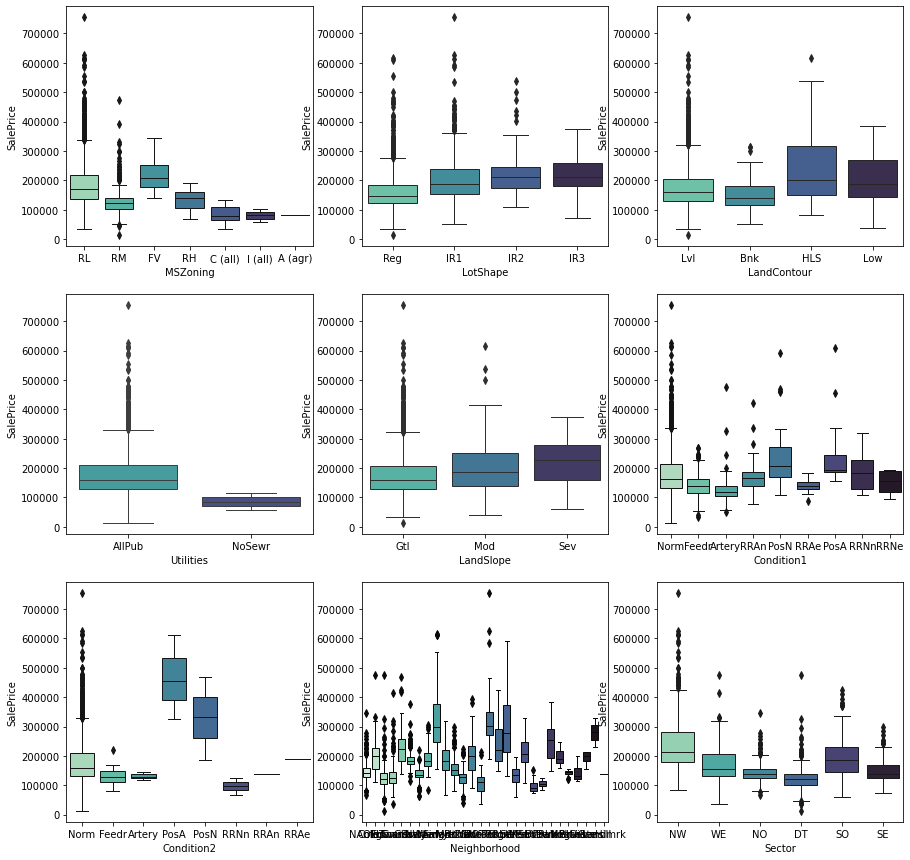

In [15]:
fig, ax = plt.subplots(3,3, figsize=(15,15))

for idx, COL in enumerate(landfeats.drop('LotArea', axis=1).columns):
    sns.boxplot(ax=ax[idx//3,idx%3],
            x=land_all[COL], y=land_all['SalePrice'], 
            order = land_all[COL].value_counts().index,
            palette="mako_r", linewidth=1)

### Findings
* LotShape and LandContour and LandSlope: may not be useful. Similar SalePrice, and concentrated in 1-2 categories
* Utilities: only 2 houses have 'No Sewer', rest are same
* Condition1 & Condition2: may be useful if a house is of PosN or PosA category, otherwise, not much use.

## <span style="color:darkred">General House</span> Features 📐
* MasVnrType, MasVnrArea, BldgType, HouseStyle, YearBuilt, YearRemodAdd, OverallQual, OverallCond

In [16]:
general = data[['MSSubClass','MasVnrType', 'MasVnrArea', 'BldgType', 
                'HouseStyle', 'YearBuilt', 'YearRemodAdd', 
                'OverallQual', 'OverallCond']]

In [17]:
general.head(3)

,MSSubClass,MasVnrType,MasVnrArea,BldgType,HouseStyle,YearBuilt,YearRemodAdd,OverallQual,OverallCond
PID,,,,,,,,,
526301100,20,Stone,112.0,1Fam,1Story,1960,1960,6,5
526302030,20,Stone,28.0,1Fam,1Story,1954,1954,6,5
526302040,20,BrkFace,244.0,1Fam,1Story,1956,1956,6,6


In [18]:
#Check Missing
general.isna().sum(axis=0)

MSSubClass       0
MasVnrType      14
MasVnrArea      14
BldgType         0
HouseStyle       0
YearBuilt        0
YearRemodAdd     0
OverallQual      0
OverallCond      0
dtype: int64

In [19]:
#Fill with "None" and 0
general = general.fillna({'MasVnrType':'None', 'MasVnrArea':0})
general.MasVnrType.isna().sum() + general.MasVnrArea.isna().sum()

0

In [20]:
np.round(general.MSSubClass.value_counts(normalize=True).sort_index()*100,2)

20     36.41
30      4.77
40      0.23
45      0.66
50     10.00
60     19.46
70      4.50
75      0.81
80      4.23
85      1.67
90      3.37
120     6.55
150     0.04
160     4.65
180     0.58
190     2.06
Name: MSSubClass, dtype: float64

<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

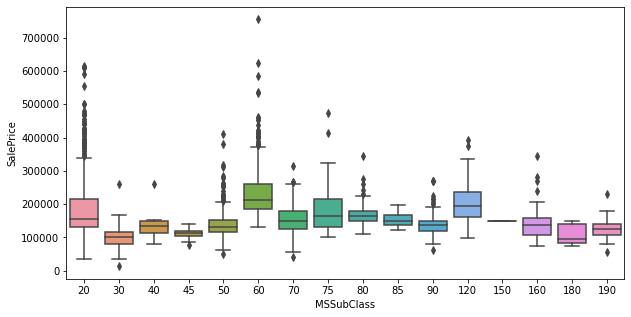

In [21]:
#Plot HouseClass
plt.figure(figsize=(10,5))
sns.boxplot(x=general.MSSubClass, y=y)

####  MSSubClass: Type of dwelling
        20	1-STORY 1946 & NEWER ALL STYLES
        30	1-STORY 1945 & OLDER
        40	1-STORY W/FINISHED ATTIC ALL AGES
        45	1-1/2 STORY - UNFINISHED ALL AGES
        50	1-1/2 STORY FINISHED ALL AGES
        60	2-STORY 1946 & NEWER
        70	2-STORY 1945 & OLDER
        75	2-1/2 STORY ALL AGES
        80	SPLIT OR MULTI-LEVEL
        85	SPLIT FOYER
        90	DUPLEX - ALL STYLES AND AGES
       120	1-STORY PUD (Planned Unit Development) - 1946 & NEWER
       150	1-1/2 STORY PUD - ALL AGES
       160	2-STORY PUD - 1946 & NEWER
       180	PUD - MULTILEVEL - INCL SPLIT LEV/FOYER
       190	2 FAMILY CONVERSION - ALL STYLES AND AGES

#### Convert to:
    1Fl = 20,30,40,45,50
    2Fl = 60,70,75
    SPLIT = 80,85
    1FlPUD = 120,150
    2FlPUD = 160,180
    DUP2FAM = 90,190

In [22]:
conv_dict = {}
for k in [20,30,40,45,50]:
    conv_dict[k] = '1Fl'
for k in [60,70,75]:
    conv_dict[k] = '2Fl'
for k in [80,85]:
    conv_dict[k] = 'SPLIT'
for k in [120,150]:
    conv_dict[k] = '1FlPUD'
for k in [160,180]:
    conv_dict[k] = '2FlPUD'
for k in [90,190]:
    conv_dict[k] = 'DUP2FAM'

    
general.loc[:,'MSSubClass'] = general.loc[:,'MSSubClass'].apply(lambda r: conv_dict[r])

In [23]:
general.MSSubClass.value_counts()

1Fl        1343
2Fl         639
1FlPUD      170
SPLIT       152
DUP2FAM     140
2FlPUD      135
Name: MSSubClass, dtype: int64

In [29]:
for each in general.MSSubClass.unique():
    print(each)
    print(general.loc[general['MSSubClass']==each]['BldgType'].value_counts())
    print('---------------------')

1Fl
1Fam      1342
2fmCon       1
Name: BldgType, dtype: int64
---------------------
2Fl
1Fam      638
2fmCon      1
Name: BldgType, dtype: int64
---------------------
SPLIT
1Fam    152
Name: BldgType, dtype: int64
---------------------
1FlPUD
TwnhsE    146
Twnhs      20
1Fam        4
Name: BldgType, dtype: int64
---------------------
2FlPUD
Twnhs     78
TwnhsE    56
1Fam       1
Name: BldgType, dtype: int64
---------------------
DUP2FAM
Duplex    87
2fmCon    52
1Fam       1
Name: BldgType, dtype: int64
---------------------


In [20]:
general = general.join(data[['Sector','Neighborhood','SalePrice','GrLivArea']],on='PID')

<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

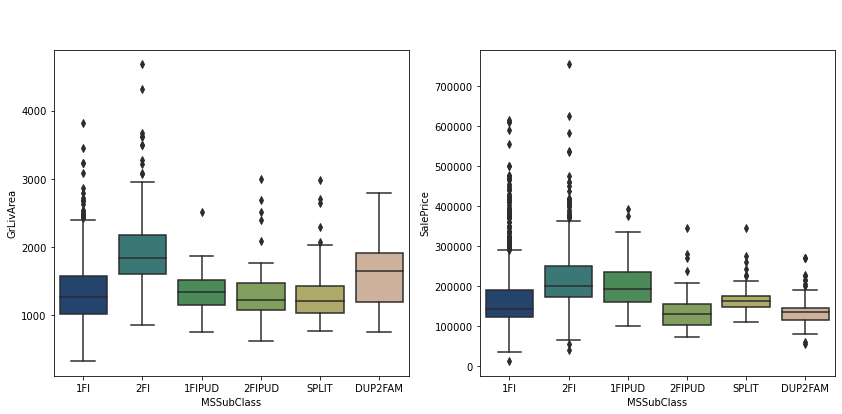

In [21]:
type_order=['1Fl','2Fl','1FlPUD','2FlPUD','SPLIT','DUP2FAM']
#Plot NEW HouseClass
sns.set_palette('gist_earth')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('HouseClass: Living Area   and   Price', size=16, c='w')

sns.boxplot(ax=ax1,x=general.MSSubClass, y=general.GrLivArea, 
            palette='gist_earth' ,order=type_order)
#ax1.xaxis.label.set_color('white')
#ax1.yaxis.label.set_color('white')
#ax1.tick_params(colors='white', which='both')
sns.boxplot(ax=ax2,x=general.MSSubClass, y=general.SalePrice, order=type_order)
#ax2.xaxis.label.set_color('white')
#ax2.yaxis.label.set_color('white')
#ax2.tick_params(colors='white', which='both')

## <span style="color:red">Findings</span>: 2Fl PUD, Duplexes, and 2Fam conversions are priced low (esp. relative to their size)

In [22]:
# percentage of houseClass in each Sector of city
temp = general.groupby(['Sector'])['MSSubClass'].value_counts(normalize=True).to_frame()
temp.rename(columns={'MSSubClass':'HouseType'}, inplace=True)
temp.reset_index(inplace=True)
temp = temp.pivot(index='MSSubClass',columns='Sector', values='HouseType')
temp

Sector,DT,NO,NW,SE,SO,WE
MSSubClass,,,,,,
1Fl,0.666667,0.672451,0.304035,0.384058,0.550,0.572872
1FlPUD,NaN,0.032538,0.152738,0.072464,0.065,0.037518
2Fl,0.234097,0.056399,0.423631,0.079710,0.245,0.240981
2FlPUD,0.002545,0.088937,0.063401,0.217391,0.035,0.017316
DUP2FAM,0.089059,0.071584,0.008646,0.079710,0.070,0.059163
SPLIT,0.007634,0.078091,0.047550,0.166667,0.035,0.072150


Text(0, 0.5, 'Proportion')

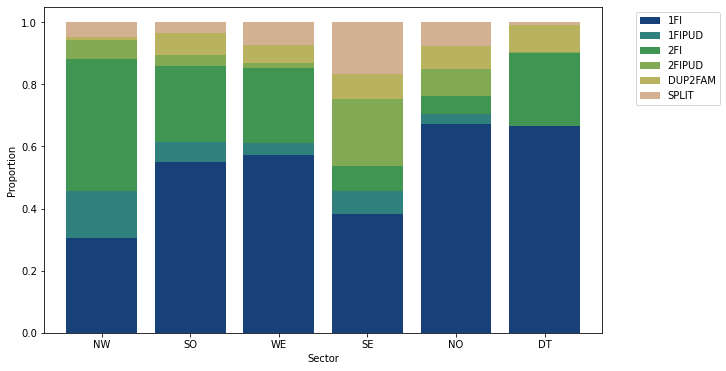

In [23]:
sec_order=['NW','SO','WE','SE','NO','DT']
fig, ax1 = plt.subplots()
temp.loc[:,sec_order].T.plot(ax=ax1, kind='bar', rot=0, width=0.8,
                           stacked=True, figsize=(10,6)).legend(bbox_to_anchor=(1.051, 1.0));
ax1.set_ylabel('Proportion')

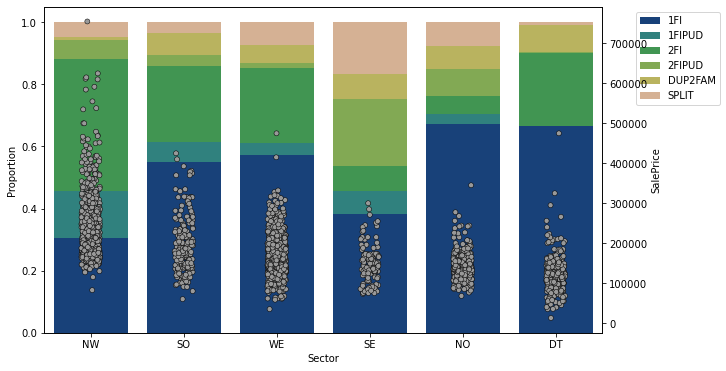

In [24]:
fig, ax1 = plt.subplots()
temp.loc[:,sec_order].T.plot(ax=ax1, kind='bar', rot=0, width=0.8,
                             stacked=True, figsize=(10,6)).legend(bbox_to_anchor=(1.051, 1.0));
ax1.set_ylabel('Proportion')
ax2 = ax1.twinx()
sns.stripplot(ax=ax2, x='Sector', y='SalePrice', data=general, order=sec_order,
              color='0.6', edgecolor='k', linewidth=0.5);

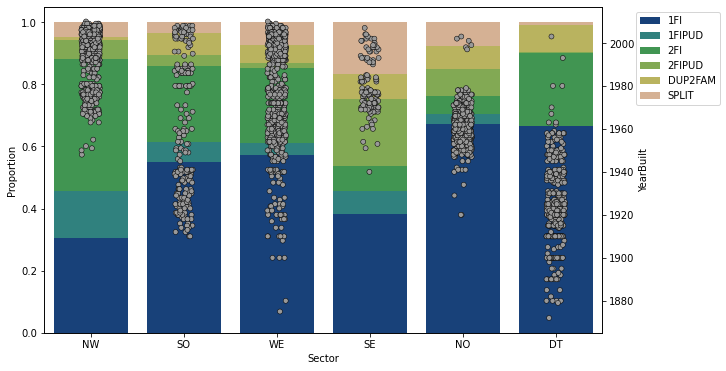

In [25]:
fig, ax1 = plt.subplots()
temp.loc[:,sec_order].T.plot(ax=ax1, kind='bar', rot=0, width=0.8,
                             stacked=True, figsize=(10,6)).legend(bbox_to_anchor=(1.051, 1.0));
ax1.set_ylabel('Proportion')
ax2 = ax1.twinx()
sns.stripplot(ax=ax2, x='Sector', y='YearBuilt', data=general, order=sec_order,
              color='0.6', edgecolor='k', linewidth=0.5);

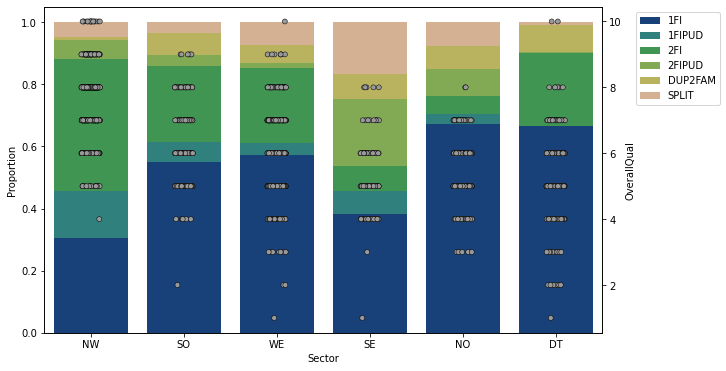

In [26]:
fig, ax1 = plt.subplots()
temp.loc[:,sec_order].T.plot(ax=ax1, kind='bar', rot=0, width=0.8,
                             stacked=True, figsize=(10,6)).legend(bbox_to_anchor=(1.051, 1.0));
ax1.set_ylabel('Proportion')
ax2 = ax1.twinx()
sns.stripplot(ax=ax2, x='Sector', y='OverallQual', data=general, order=sec_order,
              color='0.6', edgecolor='k', linewidth=0.5);

In [27]:
general.head()

,MSSubClass,MasVnrType,MasVnrArea,BldgType,HouseStyle,YearBuilt,YearRemodAdd,OverallQual,OverallCond,Sector,Neighborhood,SalePrice,GrLivArea
PID,,,,,,,,,,,,,
526301100,1Fl,Stone,112.0,1Fam,1Story,1960,1960,6,5,NO,NAmes,215000,1656
526302030,1Fl,Stone,28.0,1Fam,1Story,1954,1954,6,5,NO,NAmes,149900,1293
526302040,1Fl,BrkFace,244.0,1Fam,1Story,1956,1956,6,6,NO,NAmes,157500,1024
526302110,1Fl,None,0.0,1Fam,1Story,1956,1956,6,5,NO,NAmes,124500,882
526302120,1Fl,Stone,302.0,1Fam,1Story,1957,1957,5,5,NO,NAmes,169000,1797


## <span style="color:red">Findings</span>: 
#### DT House prices being low is mainly due to the AGE/Quality of the houses
#### SE House prices being low due to Quality and Location

In [49]:
# Export data for APP
App_data = pd.read_csv('APP_data.csv', index_col='PID')
App_data.drop(['Color','DfromWalmart'], axis=1, inplace=True)

In [50]:
App_data.columns

Index(['x_merc', 'y_merc', 'Neighborhood', 'Sector', 'SalePrice', 'latitude',
       'longitude', 'le_Neighbor', 'le_Sector'],
      dtype='object')

In [51]:
App_data.join(
    general.drop(
        ['Neighborhood', 'Sector', 'SalePrice','MasVnrType','MasVnrArea','BldgType','HouseStyle','OverallCond'],
        axis=1)).to_csv('APP_data_all.csv')

### Price per SqFt <span style="color:teal">(Groupby Sector)</span>

In [28]:
pxperSF = {}
lm = LinearRegression()
for sector in general.Sector.unique():
    X = general.loc[general['Sector']==sector][['GrLivArea']]
    y = general.loc[general['Sector']==sector]['SalePrice']
    lm.fit(np.log10(X),np.log10(y))
        
    SF_range = np.arange(min(X.GrLivArea),max(X.GrLivArea),1)
    pxperSF[sector] = {n : 10**lm.intercept_*n**(lm.coef_-1)[0] for n in SF_range}
sector_pxperSF = pd.DataFrame(pxperSF)

### Price per SqFt <span style="color:teal">(Groupby HouseType)</span>

In [29]:
pxperSF = {}
lm = LinearRegression()
for housetype in general.MSSubClass.unique():
    X = general.loc[general['MSSubClass']==housetype][['GrLivArea']]
    y = general.loc[general['MSSubClass']==housetype]['SalePrice']
    lm.fit(np.log10(X),np.log10(y))
        
    SF_range = np.arange(min(X.GrLivArea),max(X.GrLivArea),1)
    pxperSF[housetype] = {n : 10**lm.intercept_*n**(lm.coef_-1)[0] for n in SF_range}
type_pxperSF = pd.DataFrame(pxperSF)

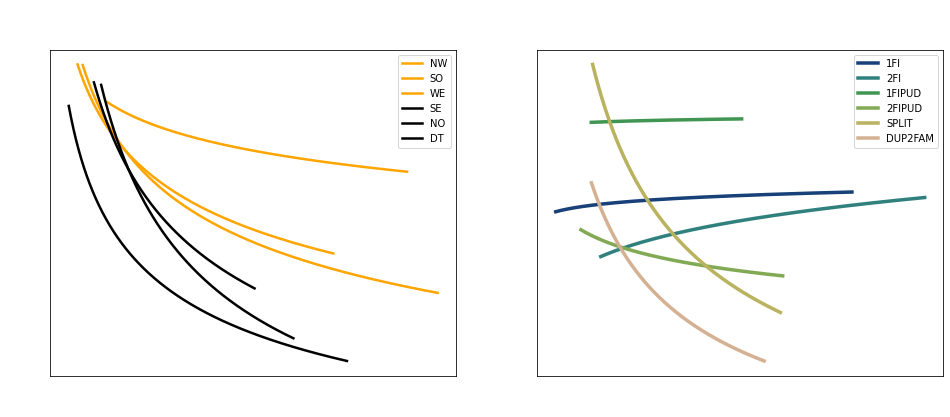

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
fig.suptitle('Price per SqFt', size=16,  color='white')

for sector, color in zip(sec_order,['orange','orange','orange','k','k','k']):
    sns.lineplot(ax=ax1, x=sector_pxperSF.index, y=sector ,data=sector_pxperSF, 
                 color=color, label=sector, linewidth=2.5);
    ax1.set_title('by Sector', color='white')
    ax1.set_ylabel('Price per SF', size=12)
    ax1.set_xlabel('Square Footage', size=12)
    ax1.xaxis.label.set_color('white')
    ax1.yaxis.label.set_color('white')
    ax1.tick_params(colors='white', which='both')
for housetype in type_order:
    sns.lineplot(ax=ax2, x=type_pxperSF.index, y=housetype ,data=type_pxperSF, 
                 label=housetype, linewidth=3.5);
    ax2.set_title('by HouseType', color='white')
    ax2.set_ylabel('Price per SF', size=12)
    ax2.set_xlabel('Square Footage', size=12)
    ax2.xaxis.label.set_color('white')
    ax2.yaxis.label.set_color('white')
    ax2.tick_params(colors='white', which='both')

### Trends in House Size and Year Built?

<AxesSubplot:xlabel='YearBuilt', ylabel='GrLivArea'>

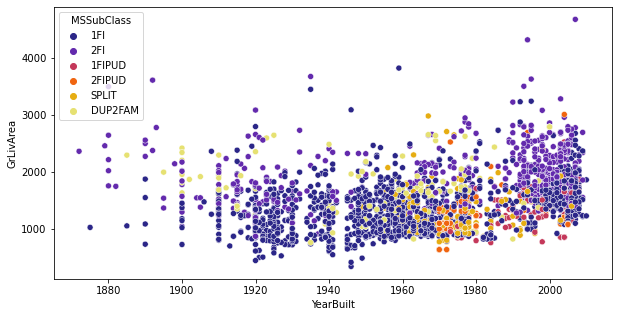

In [88]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='YearBuilt', y='GrLivArea', hue='MSSubClass', data=general, hue_order=type_order)

### Effect of remodeling?

<AxesSubplot:xlabel='Remodeled', ylabel='SalePrice'>

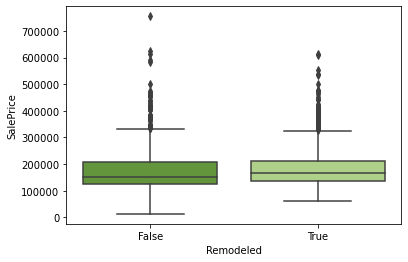

In [31]:
general['Remodeled'] = general.YearBuilt == general.YearRemodAdd
sns.boxplot(x=general.Remodeled, y=general.SalePrice)

In [118]:
#Check Categorical counts
for COL in general.drop(['MasVnrArea','YearBuilt','YearRemodAdd'],axis=1).columns:
    print(general[COL].value_counts())

1Fl        1343
2Fl         639
1FlPUD      170
SPLIT       152
DUP2FAM     140
2FlPUD      135
Name: MSSubClass, dtype: int64
None       1572
BrkFace     804
Stone       183
BrkCmn       20
Name: MasVnrType, dtype: int64
1Fam      2138
TwnhsE     202
Twnhs       98
Duplex      87
2fmCon      54
Name: BldgType, dtype: int64
1Story    1288
2Story     773
1.5Fin     283
SLvl       118
SFoyer      70
2.5Unf      22
1.5Unf      19
2.5Fin       6
Name: HouseStyle, dtype: int64
5     752
6     669
7     525
8     290
4     195
9      80
3      32
10     20
2      13
1       3
Name: OverallQual, dtype: int64
5    1402
6     497
7     360
8     140
4      88
9      41
3      39
2       8
1       4
Name: OverallCond, dtype: int64
NO    793
SW    641
NW    614
DT    393
SE    138
Name: Sector, dtype: int64
NAmes      410
CollgCr    236
OldTown    213
Edwards    165
Somerst    143
Gilbert    143
Sawyer     139
NWAmes     123
NridgHt    121
SawyerW    113
Mitchel    104
BrkSide    103
Crawfor     

In [120]:
y = data.SalePrice.copy()

Plot Numerical Features with SalePrice

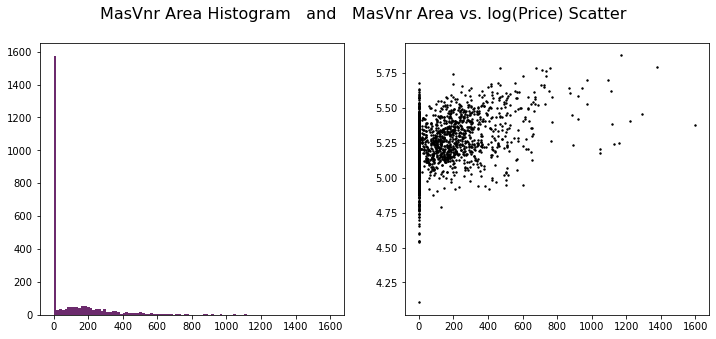

In [121]:
#Plot MasVnrArea
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('MasVnr Area Histogram   and   MasVnr Area vs. log(Price) Scatter', size=16)

ax1.hist(general.MasVnrArea, bins=100)
ax2.scatter(x=general.MasVnrArea,y=np.log10(y),s=2,c='k')

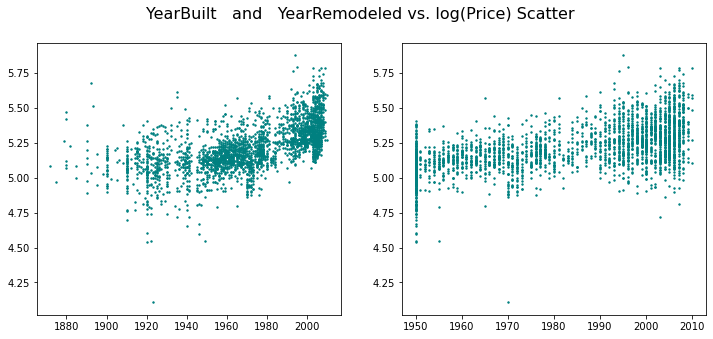

In [122]:
#Plot Year Built
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('YearBuilt   and   YearRemodeled vs. log(Price) Scatter', size=16)

ax1.scatter(x=general.YearBuilt,y=np.log10(y),s=2,c='teal')
ax2.scatter(x=general.YearRemodAdd,y=np.log10(y),s=2,c='teal')

In [123]:
lm = LinearRegression()
lm.fit(general[['YearBuilt','YearRemodAdd']],y)
lm.score(general[['YearBuilt','YearRemodAdd']],y)

0.35793128073777514

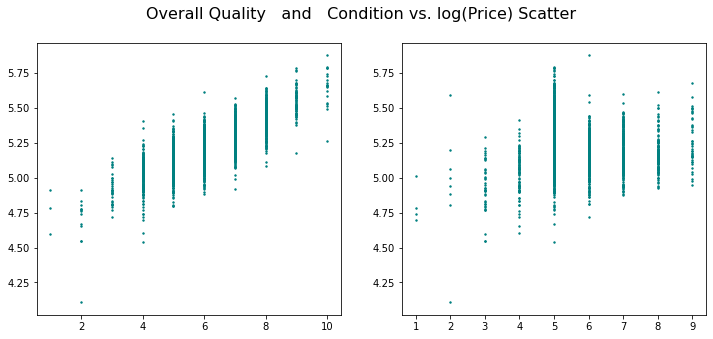

In [124]:
#Plot Quality and Condition
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('Overall Quality   and   Condition vs. log(Price) Scatter', size=16)

ax1.scatter(x=general.OverallQual,y=np.log10(y),s=2,c='teal')
ax2.scatter(x=general.OverallCond,y=np.log10(y),s=2,c='teal')

In [125]:
lm = LinearRegression()
lm.fit(general[['OverallQual','OverallCond']],y)
lm.score(general[['OverallQual','OverallCond']],y)

0.6257934465721093

In [126]:
lm = LinearRegression()
lm.fit(general[['OverallQual']],y)
lm.score(general[['OverallQual']],y)

0.6251450369427116

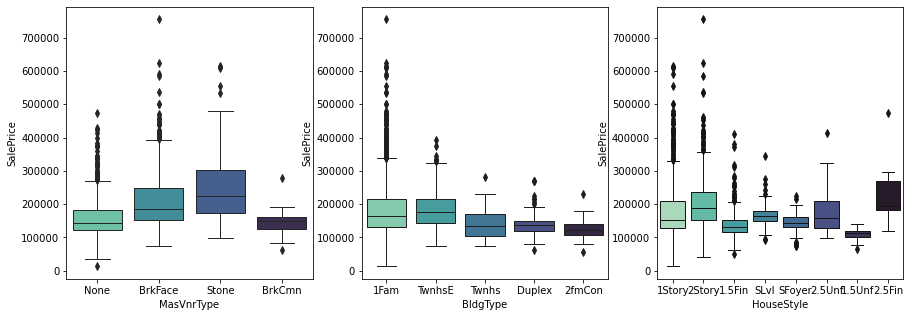

In [128]:
# Plot MasVnrTYPE, BldgType, HouseStyle, 
fig, ax = plt.subplots(1,3, figsize=(15,5))

for idx, COL in enumerate(['MasVnrType', 'BldgType', 'HouseStyle']):
    sns.boxplot(ax=ax[idx],
            x=general[COL], y=y, 
            order = general[COL].value_counts().index,
            palette="mako_r", linewidth=1)

## <span style="color:darkred">Size Related</span> Features 📐
* Columns with "SF" / "AREA" / "Porch Size"

In [129]:
size_related = data.filter(regex='SF$|Area$|(Porch)')
size_related.isnull().sum(axis=0)

GrLivArea         0
LotArea           0
MasVnrArea       14
BsmtUnfSF         1
TotalBsmtSF       1
1stFlrSF          0
2ndFlrSF          0
LowQualFinSF      0
GarageArea        1
WoodDeckSF        0
OpenPorchSF       0
EnclosedPorch     0
3SsnPorch         0
ScreenPorch       0
PoolArea          0
dtype: int64

In [130]:
size_related = size_related.fillna(0.0)  # We fill the very minor missing values by 0.0

#### GrLivArea is just 1stFl + 2ndFl

In [131]:
size_related.GrLivArea.head(20) == size_related['1stFlrSF'].head(20)+size_related['2ndFlrSF'].head(20)

PID
526301100    True
526302030    True
526302040    True
526302110    True
526302120    True
526350040    True
526351010    True
526351030    True
526351100    True
526352080    True
526352090    True
526353030    True
526353050    True
526354020    True
526354070    True
526355080    True
526355170    True
526355190    True
527105010    True
527105030    True
dtype: bool

### Create new Feature called <span style="color:blue">PorchArea</span> (Sum of all Porch & Deck)
* WoodDeckSF + OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch

In [132]:
size_related['PorchArea'] = size_related[['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']].sum(axis=1)

In [133]:
#Drop unnecessary columns
size_related.drop(['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'],axis=1,inplace=True)

<AxesSubplot:>

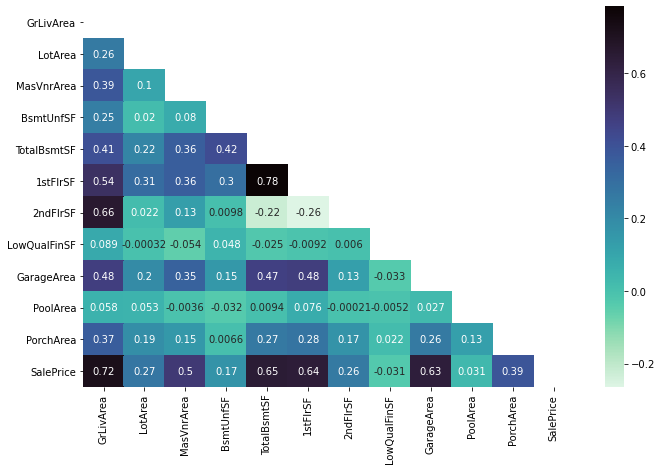

In [134]:
corr = pd.concat([size_related, y], axis=1).corr()

# Hide upper redundant heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(11, 7))
sns.heatmap(corr, mask=mask, annot=True, cmap='mako_r')

### Investigate GrLivArea (largest correlation with Sale Price 0.72)

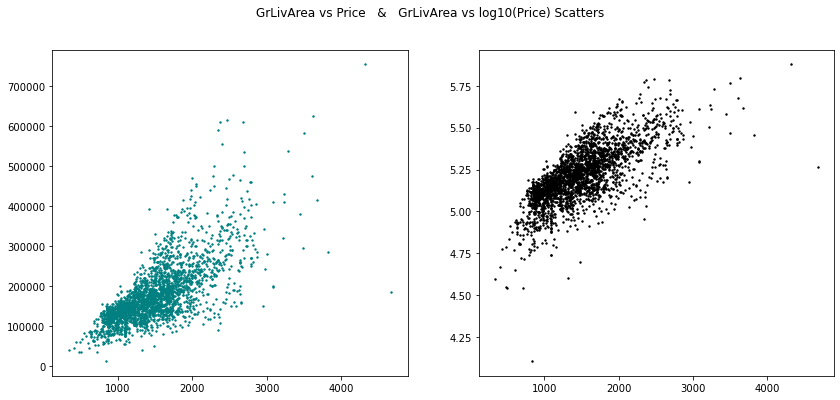

In [135]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('GrLivArea vs Price   &   GrLivArea vs log10(Price) Scatters')

ax1.scatter(x=size_related.GrLivArea,y=y,s=2,c='teal')
ax2.scatter(x=size_related.GrLivArea,y=np.log10(y),s=2,c='k')

In [136]:
lm = LinearRegression()
lm.fit(np.log10(size_related[['GrLivArea']]),np.log10(y))
print(f"R2: {lm.score(np.log10(size_related[['GrLivArea']]),np.log10(y))}")
print(f'B1: {lm.coef_}')

R2: 0.5400663903547829
B1: [0.88111154]


#### Check Scatterplot for others

In [137]:
size_related.columns

Index(['GrLivArea', 'LotArea', 'MasVnrArea', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GarageArea', 'PoolArea',
       'PorchArea'],
      dtype='object')

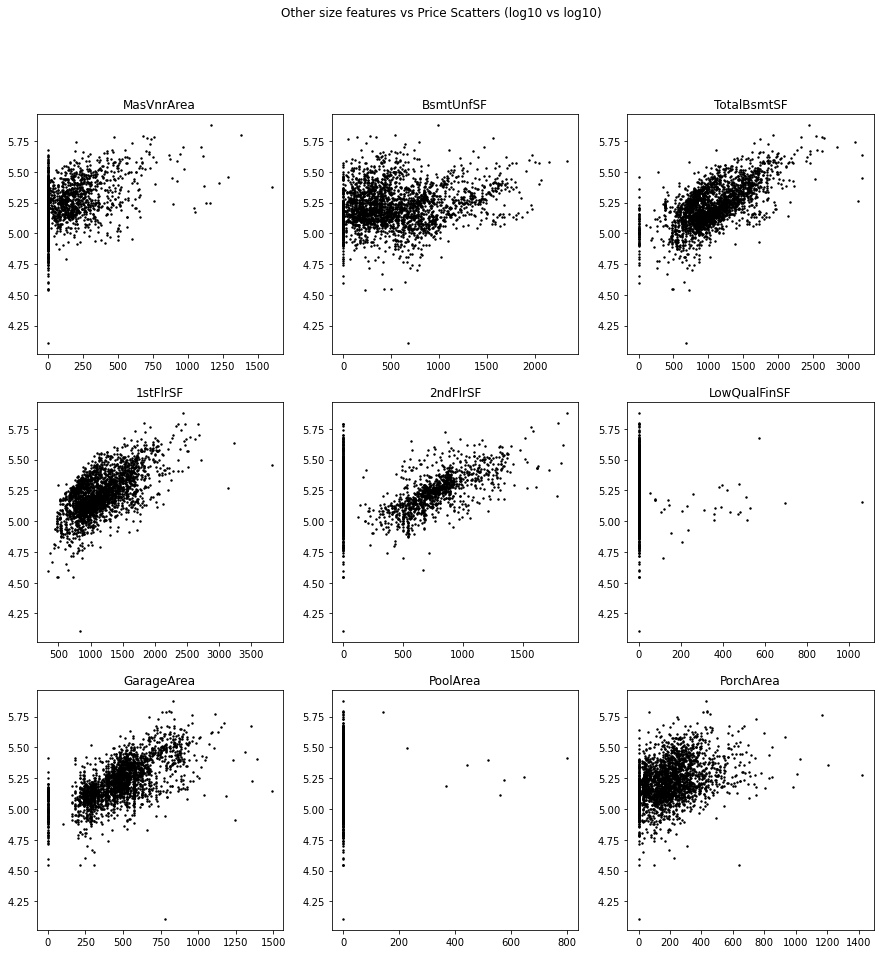

In [138]:
fig, ax = plt.subplots(3,3, figsize=(15,15))
fig.suptitle('Other size features vs Price Scatters (log10 vs log10)')

for idx, COL in enumerate(size_related.drop(['GrLivArea','LotArea'],axis=1).columns):
    ax[idx//3,idx%3].scatter(x=size_related[COL],y=np.log10(y), s=2,c='k')
    ax[idx//3,idx%3].set_title(str(COL))

#### <span style="color:blue">1stFlr, Bsmt, 2ndFlr, Garage</span> might be useful

### Create new Feature called <span style="color:blue">LBratio</span> (Land to Building Ratio)
* LotArea / 1stFlrSF

In [139]:
size_related['LBratio'] = size_related.LotArea/size_related['1stFlrSF']

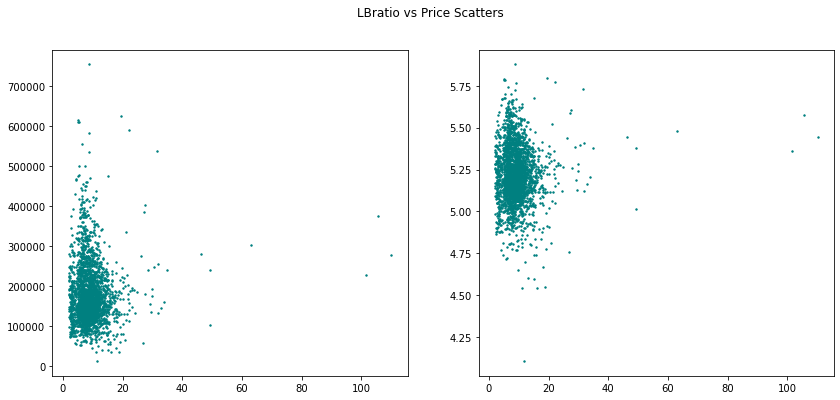

In [140]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('LBratio vs Price Scatters')

ax1.scatter(x=size_related.LBratio,y=y,s=2,c='teal')
ax2.scatter(x=size_related.LBratio,y=np.log10(y),s=2,c='teal')

#### 💩 <span style="color:red">WORTHLESS</span>, get rid of it

In [141]:
size_related.drop('LBratio',axis=1, inplace=True)

### Basement info not yet utilized, create feature called <span style="color:blue">BsmtFinSF</span> (SF of Finished Basement)
* (TotalBsmtSF - BsmtUnfSF)

In [145]:
size_related['BsmtFinSF'] = size_related.TotalBsmtSF - size_related.BsmtUnfSF

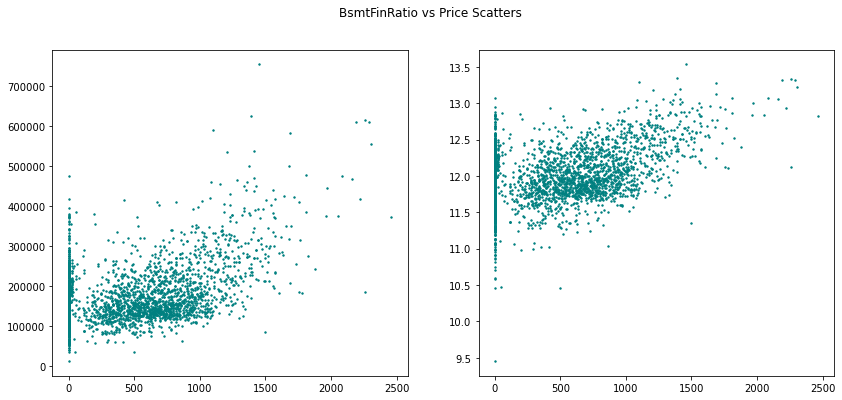

In [148]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('BsmtFin vs Price Scatters')

ax1.scatter(x=size_related.BsmtFinSF,y=y,s=2,c='teal')
ax2.scatter(x=size_related.BsmtFinSF,y=np.log(y),s=2,c='teal')

#### 💩 <span style="color:red">Not better than BsmtTotalSF</span>, get rid of it

In [149]:
size_related.drop('BsmtFinSF',axis=1, inplace=True)

### Create feature called <span style="color:blue">ALLSF</span> (SF of 1Fl + 2Fl + Bsmt + Garage)

In [162]:
size_related['ALLSF'] = size_related['1stFlrSF'] + \
    size_related['2ndFlrSF'] + size_related.TotalBsmtSF + \
    size_related.GarageArea + size_related.PorchArea

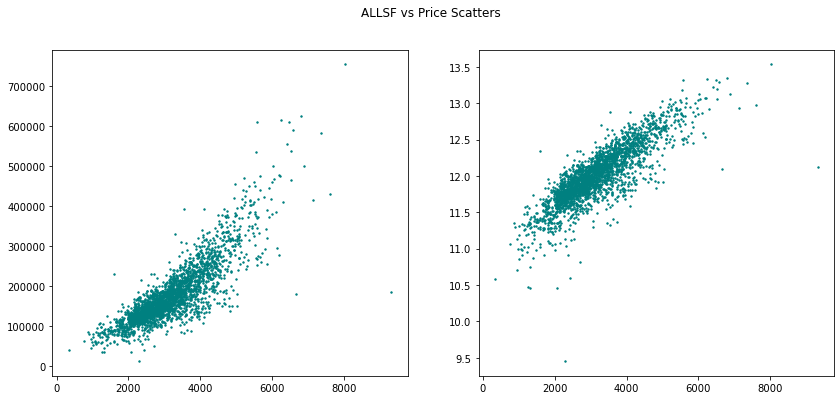

In [163]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('ALLSF vs Price Scatters')

ax1.scatter(x=size_related.ALLSF,y=y,s=2,c='teal')
ax2.scatter(x=size_related.ALLSF,y=np.log(y),s=2,c='teal')

In [164]:
lm = LinearRegression()
lm.fit(np.log10(size_related[['ALLSF']]),np.log10(y))
print(f"R2: {lm.score(np.log10(size_related[['ALLSF']]),np.log10(y))}")
print(f'B1: {lm.coef_}')

R2: 0.7078402760874029
B1: [1.04053479]


# MISC

#### Lot Frontage Feet

In [180]:
data.LotFrontage.describe()

count    2117.000000
mean       68.510628
std        22.839861
min        21.000000
25%        57.000000
50%        68.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

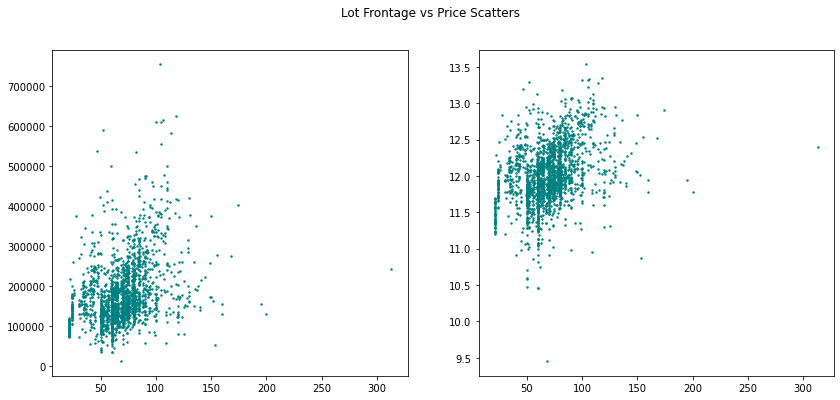

In [181]:
#Set plot size
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('Lot Frontage vs Price Scatters')

ax1.scatter(x=data.LotFrontage,y=y,s=2,c='teal')
ax2.scatter(x=data.LotFrontage,y=np.log(y),s=2,c='teal')

#### Garage Type

In [178]:
data.GarageType.value_counts()

Attchd     1526
Detchd      716
BuiltIn     153
Basment      27
2Types       21
CarPort       9
Name: GarageType, dtype: int64

<AxesSubplot:xlabel='GarageType', ylabel='SalePrice'>

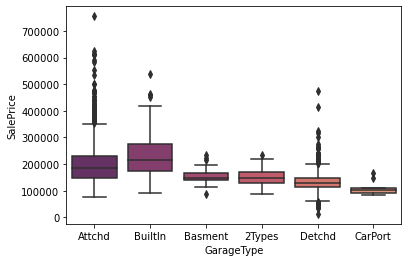

In [179]:
sns.boxplot(x=data.GarageType, y=y)